In [1]:
# Load model directly
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
from PIL import Image, ImageFilter
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
%reload_ext autoreload
%autoreload 2
import models

import torch
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from scipy import ndimage
from skimage.measure import regionprops

processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-640-1280")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-640-1280")


/home/kafkaon1/miniconda3/envs/mlenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kafkaon1/miniconda3/envs/mlenv/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [2]:
from models import DeepLabv3Plus

model = DeepLabv3Plus(num_classes=1)

ckpt = torch.load('/home/kafkaon1/Dev/out/SolAR_DLV3Pl/0724_090541/best_ckpt_ep4.pth', map_location='cpu')
model.load_state_dict(ckpt['state_dict'])


<All keys matched successfully>

In [3]:
torch.save(model.state_dict(), 'besk_cpt.pth')

In [4]:
torch.load('besk_cpt.pth')

OrderedDict([('model.encoder.conv1.weight',
              tensor([[[[ 2.2498e-02,  3.2682e-02,  1.8588e-03,  ..., -2.1592e-02,
                         -1.5379e-02, -3.6870e-02],
                        [ 1.9584e-02,  2.8766e-02,  3.7181e-02,  ...,  3.9820e-02,
                          1.6369e-02, -1.8284e-02],
                        [ 4.3650e-02,  4.1084e-02,  1.5971e-02,  ...,  1.2613e-01,
                          1.0706e-01,  9.7875e-02],
                        ...,
                        [-6.0747e-03,  2.8880e-02, -3.6583e-02,  ..., -2.1073e-01,
                         -1.3775e-01,  1.4069e-02],
                        [ 1.4410e-03,  6.6801e-02,  8.3580e-02,  ...,  1.7709e-02,
                         -2.7425e-02,  1.9389e-02],
                        [-6.2995e-02, -2.4910e-02, -1.8177e-02,  ...,  4.4303e-02,
                          4.7128e-02,  2.3532e-02]],
              
                       [[ 8.0826e-03,  3.4796e-02,  4.4248e-02,  ...,  9.4282e-02,
                  

In [4]:
ckpt = torch.load('/home/kafkaon1/Dev/out/SolAR_DLV3Pl/0724_090541/best_ckpt_ep4.pth', map_location='cpu')
model = ckpt['config'].init_obj('model', models)
model.logits = False
model.load_state_dict(ckpt['state_dict'])
model.eval()

DeepLabv3Plus(
  (model): DeepLabV3Plus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (rel

In [7]:
img = Image.open('/home/kafkaon1/Dev/data/sky_test/898791_300860708.jpg')
# resize to (512, 1024

I = T.ToTensor()(img).unsqueeze(0)

In [8]:
def get_sky_mask_model(image, model, factor=0.25, kernel=3):

    input_image = cv2.resize(image, (960, 720))
    input_image = T.ToTensor()(input_image).unsqueeze(0)
    out = model(input_image)
    oute = (out.detach().cpu().numpy().squeeze() > 0.5).astype(np.uint8)
    # find connected components and filter by area
    labels, n = ndimage.label(oute)
    props = regionprops(labels)
    filtered = np.zeros_like(oute)
    for i in range(n):
        if props[i].area > 1000:
            filtered[labels == i+1] = 1

    kernel = np.ones((kernel, kernel), np.uint8)
    dilated_mask = cv2.dilate(filtered, kernel, iterations=1)
    dilated_mask = cv2.resize(dilated_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    return dilated_mask


In [118]:
out = model(I)

In [23]:
input_img = cv2.resize(np.array(img), (960, 720))
input_image = T.ToTensor()(input_img).unsqueeze(0)
out = model(input_image)

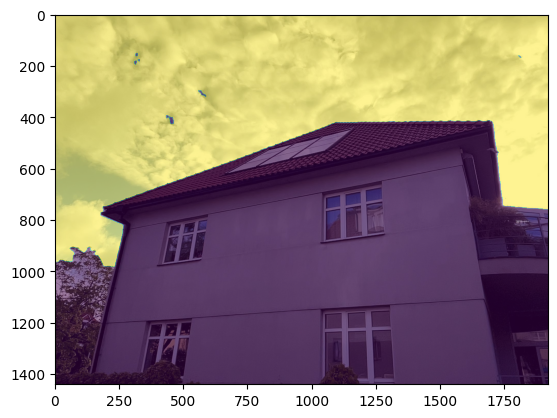

In [9]:
mask = get_sky_mask_model(np.array(img), mod)

plt.imshow(img)
plt.imshow(mask , alpha=0.5)

In [44]:
inputs = processor(images=img, return_tensors="pt")

outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
list(logits.shape)

[1, 19, 128, 128]

In [49]:
upsampled_logits = nn.functional.interpolate(outputs.logits, size=I.shape[-2:], mode="bilinear", align_corners=False)
predicted = upsampled_logits.argmax(dim=1)

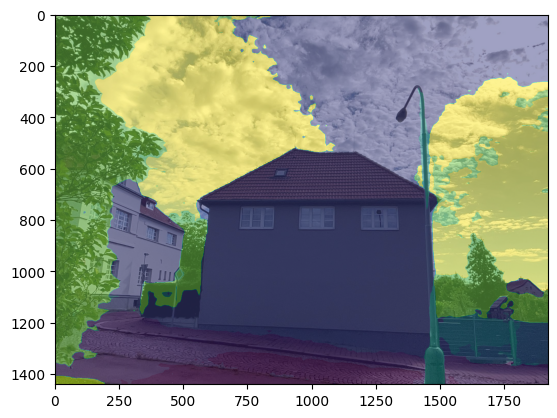

In [51]:
plt.imshow(img)
plt.imshow(predicted[0].cpu().numpy(), alpha=0.5)


In [10]:
out = model(I)

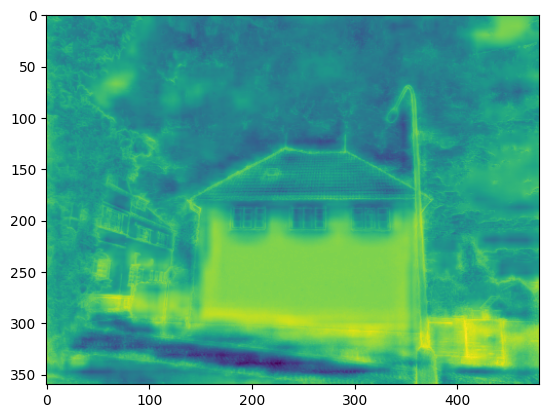

In [45]:
plt.imshow(out.to_tuple()[0][0][4].detach().cpu().numpy())